In [87]:
import re
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,  roc_curve, auc
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Ensure NLTK resources are downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package wordnet to /Users/avigarg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/avigarg/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/avigarg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/avigarg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [88]:
DATASET_COLUMNS = ['target', 'ids', 'date', 'flag', 'user', 'text']
df_simple = pd.read_csv('sentiment140.csv', encoding='ISO-8859-1', names=DATASET_COLUMNS)
df_extended = pd.read_csv('sentiment140extended.csv', encoding='ISO-8859-1', names=DATASET_COLUMNS)



In [89]:
# Combine datasets vertically (stack rows)
df_merged = pd.concat([df_simple, df_extended], ignore_index=True)


In [90]:
df_merged

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1600493,2,14072,Sun Jun 14 04:31:43 UTC 2009,latex,proggit,Ask Programming: LaTeX or InDesign?: submitted...
1600494,0,14073,Sun Jun 14 04:32:17 UTC 2009,latex,sam33r,"On that note, I hate Word. I hate Pages. I hat..."
1600495,4,14074,Sun Jun 14 04:36:34 UTC 2009,latex,iamtheonlyjosie,Ahhh... back in a *real* text editing environm...
1600496,0,14075,Sun Jun 14 21:36:07 UTC 2009,iran,plutopup7,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


In [91]:
print("Unique value counts in the target column:")
print(df_merged['target'].value_counts())

Unique value counts in the target column:
target
4    800182
0    800177
2       139
Name: count, dtype: int64


In [92]:
def clean_text(text):
    stopwordlist = [
        'a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
        'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before',
        'being', 'below', 'between', 'both', 'by', 'can', 'd', 'did', 'do',
        'does', 'doing', 'down', 'during', 'each', 'few', 'for', 'from',
        'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
        'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
        'into', 'is', 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma',
        'me', 'more', 'most', 'my', 'myself', 'needn', 'no', 'nor', 'now',
        'o', 'of', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves',
        'out', 'own', 're', 's', 'same', 'she', "shes", 'should', "shouldve", 'so', 'some', 'such',
        't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
        'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
        'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was',
        'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom',
        'why', 'will', 'with', 'won', 'y', 'you', "youd", "youll", "youre",
        "youve", 'your', 'yours', 'yourself', 'yourselves'
    ]

    # Function to get NLTK POS tag to WordNet POS tag
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)
    # Replace @mentions with 'USER'
    text = re.sub(r'@[\S]+', 'USER', text)
    # Remove hashtags but keep the text
    text = re.sub(r'#(\S+)', r'\1', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Strip leading and trailing whitespace
    text = text.strip()
    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in stopwordlist])
    # Tokenize text
    tokenizer = RegexpTokenizer(r'\w+|[^\w\s]')
    tokens = tokenizer.tokenize(text)

    # POS tagging
    pos_tags = nltk.pos_tag(tokens)

    # Lemmatize each token with the appropriate POS tag
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tags]
    
    return " ".join(lemmatized_tokens)

In [93]:
# Convert all '4' labels to '1' (positive sentiment)
df_merged['target'] = df_merged['target'].replace(4, 1)

# Preprocess text
df_merged['text'] = df_merged['text'].apply(clean_text)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_merged['text'], df_merged['target'], test_size=0.2, random_state=42)

In [ ]:

vectorizer = TfidfVectorizer(max_features=500000, ngram_range=(1,2))
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [ ]:
# 3️⃣ Oversample minority class (neutral)
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy={2: 5000}, random_state=42)
X_train_vect, y_train = ros.fit_resample(X_train_vect, y_train)


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
def evaluate_model(model):
    # Train model
    model.fit(X_train_vect, y_train)
    y_pred = model.predict(X_test_vect)
    label_names = ['negative', 'positive', 'neutral']
    print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    y_score = model.predict_proba(X_test_vect)
    for i, class_name in enumerate(label_names):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc(fpr, tpr):0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc='lower right')
    plt.show()


/Users/avigarg/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/avigarg/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/avigarg/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

    negative       0.81      0.79      0.80    159146
    positive       0.80      0.82      0.81    160942
     neutral       0.03      0.50      0.05        12

    accuracy                           0.81    320100
   macro avg       0.55      0.70      0.55    320100
weighted avg       0.81      0.81      0.81    320100



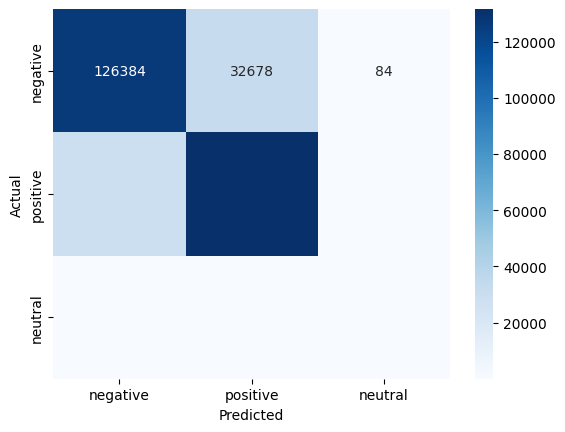

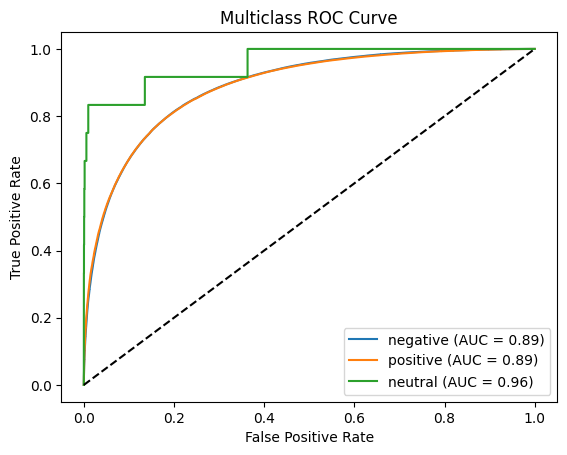

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
lr_model = OneVsRestClassifier(LogisticRegression(C=3, max_iter=1000, n_jobs=-1, class_weight='balanced', multi_class='ovr'))
evaluate_model(lr_model)

In [ ]:
test_tweet = ["I am happy that I am injured"]
test_tweet = [clean_text(test_tweet[0])]
vectorized_tweet = vectorizer.transform(test_tweet)
predicted_sentiment = lr_model.predict(vectorized_tweet)

sentiment_map = {0: "Negative", 1: "Positive", 2: "Neutral"}
print(f"Predicted Sentiment: {sentiment_map[predicted_sentiment[0]]}")

Predicted Sentiment: Negative


In [ ]:
import joblib
joblib.dump(lr_model, "sentiment_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']